# Fun with Maps

*This is work in progress*

Display random locations on a map and try to find funny shapes in them.

## Dependencies

In [ ]:
using System.Net.Http;
using System.Globalization;

using static Microsoft.DotNet.Interactive.Formatting.PocketViewTags;

var random = new Random();
var httpClient = new HttpClient();

## Step 1: Get images from map locations

### Configuration

We are using [Azure Maps](https://azure.microsoft.com/en-us/services/maps/) to retrieve the map images.

Create an [Azure Maps account](https://docs.microsoft.com/en-us/azure/azure-maps/quick-demo-map-app#create-an-azure-maps-account) and get the primary key for that account.

In [ ]:
var azureMapsSubscriptionKey = "<your-subscription-key>";

### Pick random locations

Select a random zoom level and a random location ([As per documentation](https://docs.microsoft.com/en-us/rest/api/maps/render/get-map-image))

* _Zoom level_ ranges from 0 to 20.
* _Longitude_ range: -180 to 180.
* _Latitude_ range: -85 to 85.

In [ ]:
// actual ranges are slightly different from documentation, to get more interesting results
var zoomLevelRange = 5..13;
var longitudeRange = 0..180;
var latitudeRange = 0..75;

In [ ]:
var numberOfImages = 8;

var imageLocations = Enumerable.Range(0, numberOfImages)
	.Select(i => new
	{
		ZoomLevel = random.Next(zoomLevelRange.Start.Value, zoomLevelRange.End.Value),
		Longitude = random.NextDouble() * (2 * longitudeRange.End.Value) - longitudeRange.End.Value,
		Latitude = random.NextDouble() * (2 * latitudeRange.End.Value) - latitudeRange.End.Value,
	})
	.ToArray();
display(imageLocations);

index,ZoomLevel,Longitude,Latitude
0,8,151.17338255591903,2.9815744688062154
1,9,11.662676584486348,-53.98013341366893
2,10,-136.1218954856829,-28.499639178161488
3,8,22.782745444882863,13.301881030751147
4,10,32.722732179130674,-64.56032421872021
5,11,160.60988248225925,-14.59446323547678
6,9,142.25657676094642,-9.4396415456456
7,10,35.26335553089396,3.6914883517903547


### Build the map API calls

In [ ]:
var cultureInfo = CultureInfo.InvariantCulture;

var baseUri = "https://atlas.microsoft.com/map/static/png";
var queryParameters = new Dictionary<string, string>
{
	{ "subscription-key", azureMapsSubscriptionKey },
	{ "api-version", "1.0" },
	{ "width", "256" },
	{ "height", "256" },
};

var imageUriList = imageLocations
	.Select(location => {
		queryParameters["center"] = $"{location.Longitude.ToString(cultureInfo)},{location.Latitude.ToString(cultureInfo)}";
		queryParameters["zoom"] = $"{location.ZoomLevel}";

		return new Uri(baseUri + "?" + string.Join("&", queryParameters.Select(kvp => $"{kvp.Key}={kvp.Value}")));
	})
	.ToArray();

display(imageUriList.Select(uri => uri.ToString().Replace(azureMapsSubscriptionKey, "<OBFUSCATED>")));


index,value
0,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=151.17338255591903,2.9815744688062154&zoom=8"
1,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=11.662676584486348,-53.98013341366893&zoom=9"
2,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=-136.1218954856829,-28.499639178161488&zoom=10"
3,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=22.782745444882863,13.301881030751147&zoom=8"
4,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=32.722732179130674,-64.56032421872021&zoom=10"
5,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=160.60988248225925,-14.59446323547678&zoom=11"
6,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=142.25657676094642,-9.4396415456456&zoom=9"
7,"https://atlas.microsoft.com/map/static/png?subscription-key=<OBFUSCATED>&api-version=1.0&width=256&height=256&center=35.26335553089396,3.6914883517903547&zoom=10"


### Fetch images

In [ ]:
var imageFetchingTasks = imageUriList.Select(uri => 
	httpClient.GetAsync(uri).ContinueWith(task => task.Result.Content.ReadAsByteArrayAsync()));
var images = await Task.WhenAll(imageFetchingTasks);


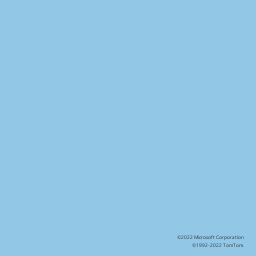
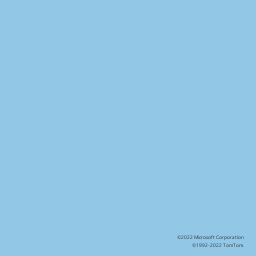
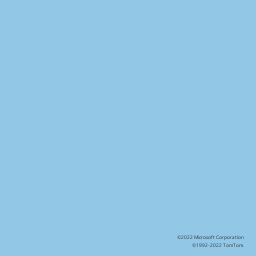
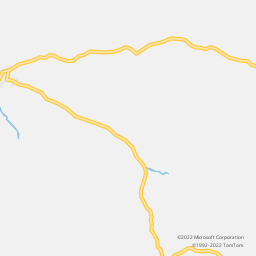
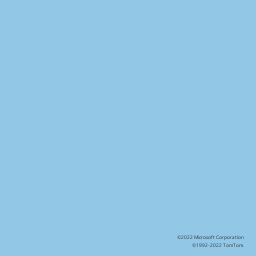
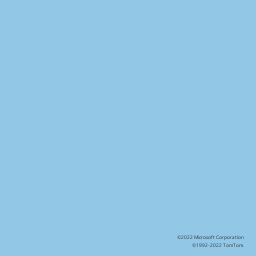
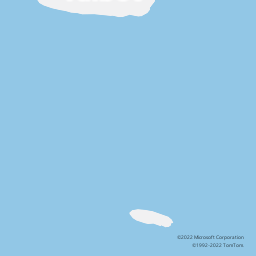
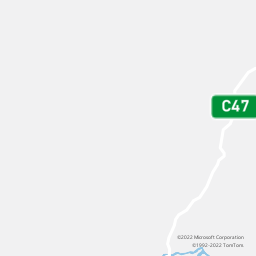

In [ ]:
display(
	HTML(
		string.Join("", images.Select(image => 
			span(
				img[src: "data:image/png;base64," + Convert.ToBase64String(image.Result), style: "padding: 15px"]
			)))
	)
);